# Skin Cancer Classification Model Notebook

## 1. Import Libraries
**Description:**
- This section imports the required libraries for:
  - Deep learning using PyTorch.
  - Data augmentation and image processing via `torchvision`.
  - Visualization tools like Matplotlib and Seaborn.
  - Evaluation metrics for classification using `sklearn`.
  - General-purpose data manipulation with NumPy and Pandas.

In [208]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score
import seaborn as sns
import numpy as np 
import pandas as pd 
import os


## 2. Device Configuration and Data Transformation
**Description:**
- The notebook checks if a GPU is available for faster computations; otherwise, it defaults to the CPU.
- Two sets of image transformations are defined:
  - **Training Transformations:** Data augmentation techniques like random cropping, flipping, rotation, and color jittering are applied to make the model robust.
  - **Testing Transformations:** Simplified preprocessing like center cropping and normalization is applied.


In [209]:
# Utilisation de GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = {
        'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust lighting
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalisation ImageNet
    ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
}

## 3. Load the Dataset
**Description:**
- The training and test datasets are loaded from local directories using `ImageFolder`.
- Training data undergoes augmentation transformations, whereas the test dataset is only normalized.

In [210]:
# Charger les jeux de données
train_dataset = datasets.ImageFolder('/kaggle/input/skin-cancer-malignant-vs-benign/train', transform=transform["train"])
test_dataset = datasets.ImageFolder('/kaggle/input/skin-cancer-malignant-vs-benign/test', transform=transform["test"])

## 3. Load the Dataset
**Description:**
- The training and test datasets are loaded from local directories using `ImageFolder`.
- Training data undergoes augmentation transformations, whereas the test dataset is only normalized.

In [211]:

# Division des données d'entraînement en ensembles d'entraînement et de validation
train_size = int(0.8 * len(train_dataset))  # 80% pour l'entraînement
val_size = len(train_dataset) - train_size  # 20% pour la validation

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 5. Load Pre-trained Models
**Description:**
- Two pre-trained models, **EfficientNet-B0** and **MobileNet-V2**, are loaded with ImageNet weights.
- These models are transferred to the GPU (if available) to accelerate computation.
- Pre-trained models leverage features learned on large datasets like ImageNet, saving training time and improving accuracy.

In [212]:
# Modèles pré-entraînés
efficientnet = models.efficientnet_b0(weights='IMAGENET1K_V1').to(device)
mobilenet = models.mobilenet_v2(weights='IMAGENET1K_V1').to(device)

In [213]:
# Remplacer la dernière couche pour la classification binaire
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, 1).to(device)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, 1).to(device)

## 6. Model Training and Evaluation
**Description:**
- This section covers:
  - Training the models using forward propagation, loss calculation, backpropagation, and optimization.
  - Evaluation on validation and test datasets to measure model performance.
  - Metrics such as accuracy, confusion matrix, and ROC-AUC score are used to evaluate the models.


In [214]:


# Fonction pour entraîner le modèle avec validation et early stopping
def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=3):
    best_val_loss = float('inf')
    epochs_without_improvement = 0  # Compter le nombre d'époques sans amélioration
    model.train()
        # Suivi des pertes et des précisions
    train_losses = []
    val_losses = []
   
    for epoch in range(epochs):
        # Entraînement
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
           
            optimizer.zero_grad()  # Réinitialiser les gradients
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())  # Loss binaire
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
       
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

          
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())  # Loss binaire
                val_loss += loss.item()
       
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
       
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0  # Réinitialiser le compteur
        else:
            epochs_without_improvement += 1
       
        if epochs_without_improvement >= patience:
            print("Early stopping triggered")
            break
       
        model.train()

    return model, train_losses, val_losses
        
   

In [215]:
# Définir la fonction de perte et l'optimiseur
criterion = nn.BCEWithLogitsLoss()  # Fonction de perte pour la classification binaire
optimizer_efficientnet = optim.Adam(efficientnet.parameters(), lr=1e-4,weight_decay=1e-5)
optimizer_mobilenet = optim.Adam(mobilenet.parameters(), lr=1e-4,weight_decay=1e-5)




In [216]:
mobilenet_trained, train_losses_mobilenet, val_losses_mobilenet = train_model_with_validation(
    mobilenet, train_loader, val_loader, criterion, optimizer_mobilenet, epochs=32, patience=3)

Epoch 1/32, Train Loss: 0.4453, Val Loss: 0.3896
Epoch 2/32, Train Loss: 0.3502, Val Loss: 0.3699
Epoch 3/32, Train Loss: 0.3115, Val Loss: 0.3381
Epoch 4/32, Train Loss: 0.2922, Val Loss: 0.3621
Epoch 5/32, Train Loss: 0.2956, Val Loss: 0.3430
Epoch 6/32, Train Loss: 0.2699, Val Loss: 0.3346
Epoch 7/32, Train Loss: 0.2779, Val Loss: 0.3181
Epoch 8/32, Train Loss: 0.2486, Val Loss: 0.3282
Epoch 9/32, Train Loss: 0.2348, Val Loss: 0.3355
Epoch 10/32, Train Loss: 0.2589, Val Loss: 0.2976
Epoch 11/32, Train Loss: 0.2056, Val Loss: 0.3351
Epoch 12/32, Train Loss: 0.2167, Val Loss: 0.3584
Epoch 13/32, Train Loss: 0.2026, Val Loss: 0.2993
Early stopping triggered


In [217]:
### Entraîner les deux modèles avec validation et early stopping
efficientnet_trained, train_losses_efficientnet, val_losses_efficientnet = train_model_with_validation(
    efficientnet, train_loader, val_loader, criterion, optimizer_efficientnet, epochs=32, patience=3)

Epoch 1/32, Train Loss: 0.5293, Val Loss: 0.4029
Epoch 2/32, Train Loss: 0.3602, Val Loss: 0.3438
Epoch 3/32, Train Loss: 0.3287, Val Loss: 0.3219
Epoch 4/32, Train Loss: 0.2948, Val Loss: 0.3238
Epoch 5/32, Train Loss: 0.2977, Val Loss: 0.2905
Epoch 6/32, Train Loss: 0.2637, Val Loss: 0.3161
Epoch 7/32, Train Loss: 0.2624, Val Loss: 0.3069
Epoch 8/32, Train Loss: 0.2499, Val Loss: 0.2820
Epoch 9/32, Train Loss: 0.2297, Val Loss: 0.3059
Epoch 10/32, Train Loss: 0.2439, Val Loss: 0.3260
Epoch 11/32, Train Loss: 0.2168, Val Loss: 0.3407
Early stopping triggered


In [218]:
# Fonction de visualisation des courbes de perte
def plot_loss_curves(train_losses, val_losses, model_name):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Curves for {model_name}')
    plt.legend()
    plt.show()

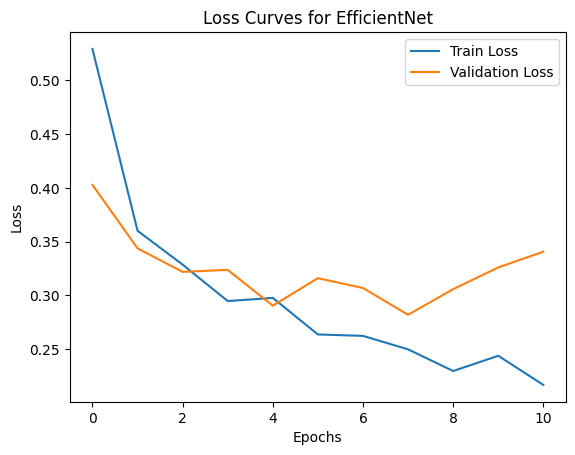

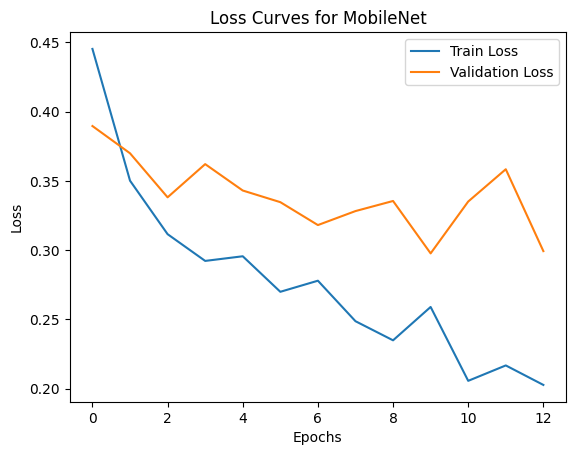

In [219]:
# Courbes de perte pour EfficientNet et MobileNet
plot_loss_curves(train_losses_efficientnet, val_losses_efficientnet, 'EfficientNet')
plot_loss_curves(train_losses_mobilenet, val_losses_mobilenet, 'MobileNet')

## 8. Results and Visualization
**Description:**
- The results of the model evaluation are visualized using:
  - **Confusion Matrix:** To understand misclassifications between classes.
  - **ROC Curve and AUC Score:** To measure the model’s ability to distinguish between classes.
- These visualizations help identify strengths and weaknesses in the model predictions.


In [220]:
# Fonction pour tester le modèle et afficher les résultats
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).squeeze() > 0.5  # Seuil pour la classification binaire
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            scores.extend(torch.sigmoid(outputs).squeeze().cpu().numpy())
   
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")
   
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=["Benign", "Malignant"], yticklabels=["Negative", "Positive"])
    plt.title("Confusion Matrix")
    plt.show()

    # Compute ROC and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, scores)
    auc = roc_auc_score(all_labels, scores)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()


Evaluating EfficientNet:
Accuracy: 0.9136


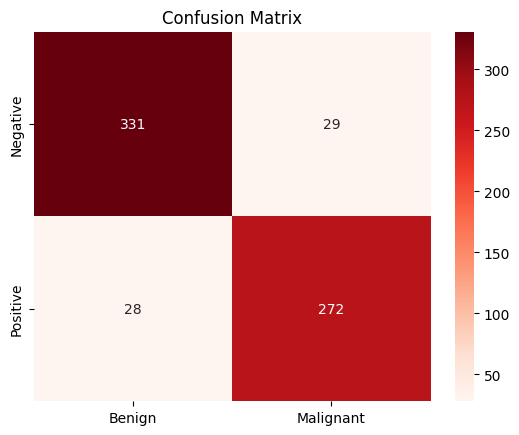

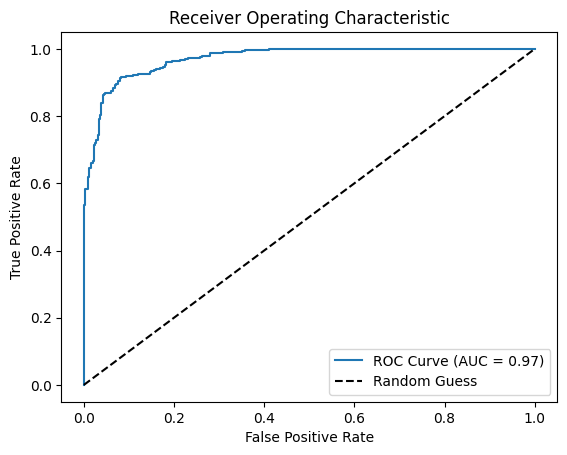

Evaluating MobileNet:
Accuracy: 0.8864


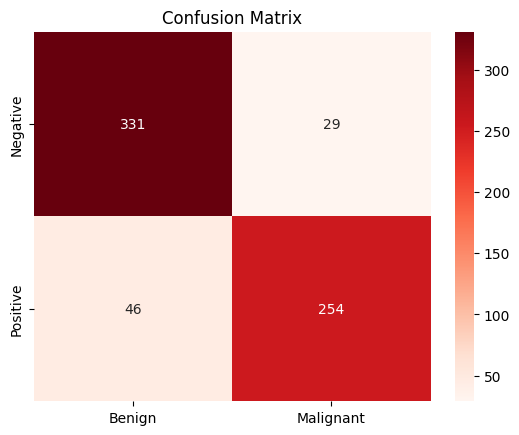

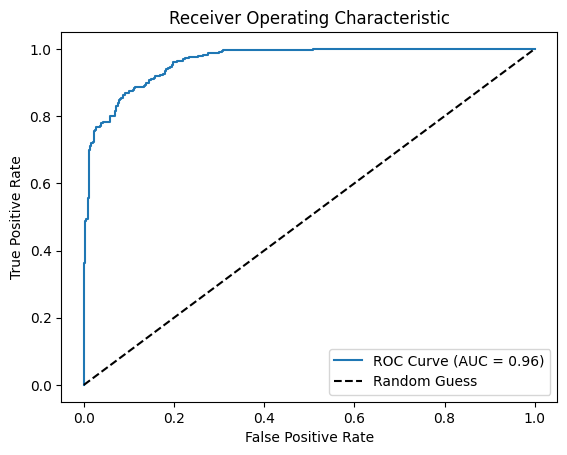

In [221]:
# Évaluation des modèles sur l'ensemble de test
print("Evaluating EfficientNet:")
evaluate_model(efficientnet_trained, test_loader)

print("Evaluating MobileNet:")
evaluate_model(mobilenet_trained, test_loader)

## 9. Deploy Model and test it

In [223]:
torch.save(efficientnet_trained, 'model_skin_cancer.pth')

/tmp/ipykernel_30/4265306061.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/kaggle/working/model_skin_cancer.pth')


tensor([[-2.0874]], device='cuda:0')
0.1103232353925705


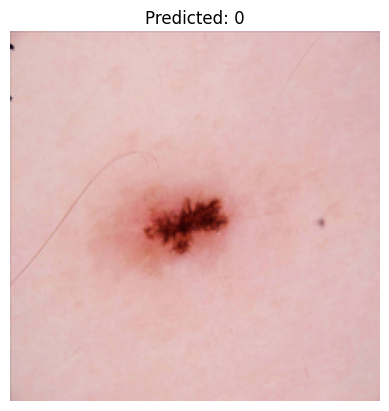

In [258]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Load the model
model = torch.load('/kaggle/working/model_skin_cancer.pth')
model = model.to(device)
model.eval()

# Load and preprocess the image
image = Image.open('/kaggle/input/skin-cancer-malignant-vs-benign/test/benign/1.jpg')
# Define the transformation (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size expected by EfficientNet
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for EfficientNet
])
input_tensor = transform(image).unsqueeze(0).to(device)

# Predict
with torch.no_grad():  # Disable gradient computation for inference
    output = model(input_tensor)
    print(output)
    pred = torch.sigmoid(output).item() 
    print(pred)
    prediction = 1 if pred > 0.5 else 0  # Set threshold for binary classification
# Visualize
plt.imshow(image)
plt.title(f"Predicted: {prediction}")
plt.axis('off')
plt.show()


### This notebook was created and developed by **Wajdi MNASRI** & **Mahmoud BECHEIKH**